# 자전거 대여량 예측 모델

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
bike = pd.read_csv('./data/bike-sharing-demand/train.csv')

# 데이터 확인

In [3]:
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


.head()를 이용하여 데이터를 확인하였다.

## 결측치 확인

In [4]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


.info()를 이용하여 결측치를 확인하였다 (count의 갯수가 다른 컬럼들 보다 낮은게 있으면 결측치가 있는거). 결측치 확인 결과 bike dataset에는 결측치가 존재하지 않는다는 것을 알게되었다.

## 이상치 확인

In [ ]:
import pandas as pd

def find_outliers_iqr(df):
    """
    DataFrame의 각 수치형 컬럼에 대해 IQR 기반 이상치를 탐지하고 출력합니다.

    Args:
        df (pd.DataFrame): 이상치를 탐지할 데이터프레임.
        
    Returns:
        dict: 각 컬럼의 이상치 데이터를 담은 딕셔너리.
    """
    outliers_data = {}
    
    # 수치형 컬럼만 선택
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    print("--- IQR 기반 이상치 탐지 결과 ---")
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # 이상치 경계 설정
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 필터링
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        
        if not outliers.empty:
            print(f"\n컬럼 '{col}'에서 발견된 이상치 (총 {len(outliers)}개):")
            print(outliers)
            outliers_data[col] = outliers
        else:
            print(f"\n컬럼 '{col}'에서 이상치가 발견되지 않았습니다.")
            
    print("\n-------------------------------")
    return outliers_data

# 함수 호출 (이전에 정의된 'bike' 데이터프레임을 사용)
outliers_found = find_outliers_iqr(bike)

--- IQR 기반 이상치 탐지 결과 ---

컬럼 'season'에서 이상치가 발견되지 않았습니다.

컬럼 'holiday'에서 발견된 이상치 (총 311개):
372      1
373      1
374      1
375      1
376      1
        ..
10257    1
10258    1
10259    1
10260    1
10261    1
Name: holiday, Length: 311, dtype: int64

컬럼 'workingday'에서 이상치가 발견되지 않았습니다.

컬럼 'weather'에서 발견된 이상치 (총 1개):
5631    4
Name: weather, dtype: int64

컬럼 'temp'에서 이상치가 발견되지 않았습니다.

컬럼 'atemp'에서 이상치가 발견되지 않았습니다.

컬럼 'humidity'에서 발견된 이상치 (총 22개):
1091    0
1092    0
1093    0
1094    0
1095    0
1096    0
1097    0
1098    0
1099    0
1100    0
1101    0
1102    0
1103    0
1104    0
1105    0
1106    0
1107    0
1108    0
1109    0
1110    0
1111    0
1112    0
Name: humidity, dtype: int64

컬럼 'windspeed'에서 발견된 이상치 (총 227개):
175      32.9975
178      36.9974
194      35.0008
196      35.0008
265      39.0007
          ...   
10013    32.9975
10154    32.9975
10263    43.0006
10540    32.9975
10853    32.9975
Name: windspeed, Length: 227, dtype: float64

컬럼 'casual'에서 발견된 이상치 (총 749

이상치를 확인하기 위해서 IQR을 사용하여 이상치 경계를 설정하였다.\
이상치의 경계는
- lower_bound = Q1 - 1.5 * IQR
- upper_bound = Q3 + 1.5 * IQR\
로 설정하였다.

In [7]:
import pandas as pd

def remove_outliers_iqr(df):
    """
    DataFrame의 각 수치형 컬럼에 대해 IQR 기반 이상치를 제거합니다.
    
    Args:
        df (pd.DataFrame): 이상치를 제거할 데이터프레임.
        
    Returns:
        pd.DataFrame: 이상치가 제거된 새로운 데이터프레임.
    """
    df_cleaned = df.copy() # 원본 데이터프레임을 수정하지 않기 위해 복사
    
    # 수치형 컬럼만 선택
    numeric_cols = df_cleaned.select_dtypes(include=['number']).columns
    
    print("--- IQR 기반 이상치 제거 시작 ---")
    
    for col in numeric_cols:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치가 아닌 데이터만 선택 (이상치 제거)
        # 조건: lower_bound <= 값 <= upper_bound
        initial_rows = len(df_cleaned)
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
        removed_rows = initial_rows - len(df_cleaned)
        
        if removed_rows > 0:
            print(f"컬럼 '{col}'에서 {removed_rows}개의 이상치 행이 제거되었습니다.")
        else:
            print(f"컬럼 '{col}'에서 제거된 이상치 행이 없습니다.")
            
    print("--- IQR 기반 이상치 제거 완료 ---")
    return df_cleaned

# 함수 호출: bike_cleaned 변수에 이상치가 제거된 새로운 데이터프레임 저장
bike_cleaned = remove_outliers_iqr(bike)

# 제거 전후 데이터프레임 행 수 비교
print(f"\n원본 데이터프레임 행 수: {len(bike)}")
print(f"이상치 제거 후 데이터프레임 행 수: {len(bike_cleaned)}")

--- IQR 기반 이상치 제거 시작 ---
컬럼 'season'에서 제거된 이상치 행이 없습니다.
컬럼 'holiday'에서 311개의 이상치 행이 제거되었습니다.
컬럼 'workingday'에서 제거된 이상치 행이 없습니다.
컬럼 'weather'에서 1개의 이상치 행이 제거되었습니다.
컬럼 'temp'에서 제거된 이상치 행이 없습니다.
컬럼 'atemp'에서 제거된 이상치 행이 없습니다.
컬럼 'humidity'에서 22개의 이상치 행이 제거되었습니다.
컬럼 'windspeed'에서 220개의 이상치 행이 제거되었습니다.
컬럼 'casual'에서 709개의 이상치 행이 제거되었습니다.
컬럼 'registered'에서 510개의 이상치 행이 제거되었습니다.
컬럼 'count'에서 24개의 이상치 행이 제거되었습니다.
--- IQR 기반 이상치 제거 완료 ---

원본 데이터프레임 행 수: 10886
이상치 제거 후 데이터프레임 행 수: 9089


각 컬럼에서 이상치가 들어있는 행을 제거하였다.

## 상관관계 확인

상관관계 (count 기준):
 count         1.000000
registered    0.984713
casual        0.711535
temp          0.335394
atemp         0.332581
season        0.166762
workingday    0.127000
windspeed     0.112027
weather      -0.099841
humidity     -0.300010
holiday            NaN
Name: count, dtype: float64


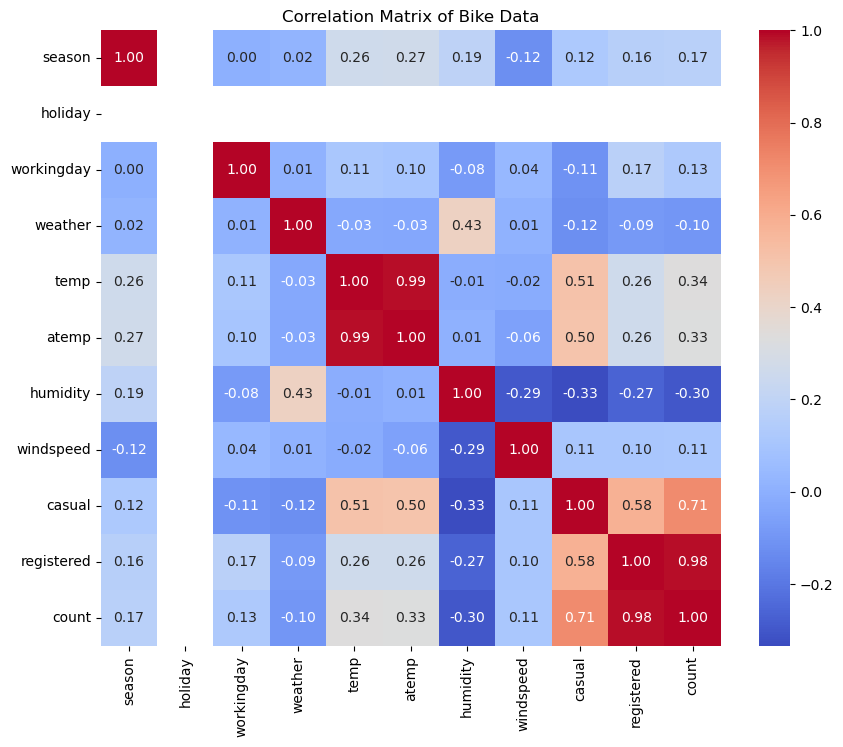

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 'count' 컬럼과의 상관관계 계산
# numeric_only=True 옵션을 사용하여 숫자형 컬럼만 포함
correlations = bike_cleaned.corr(numeric_only=True)['count'].sort_values(ascending=False)
print("상관관계 (count 기준):\n", correlations)

# 상관관계를 시각화하는 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(bike_cleaned.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Bike Data')
plt.show()

y element인 'count'와 연관이 없는 컬럼을 찾아내기 위해 correlation matrix를 사용하였다.

# 모델 만들기

In [29]:
X = bike_cleaned.drop(['datetime', 'count', 'weather', 'holiday', 'humidity', 'casual', 'registered'], axis=1).values
y = bike_cleaned['count'].values
bike_cleaned.shape

(9089, 12)

X 제외 목록
- Weather, Humidity => 상관계수가 음수
- Holiday => 상관계수가 NaN
- Casual, Registered => 둘을 합치면 결국 y element인 count

## 스케일러 객체 생성

In [134]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 156)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred[:3]

array([139.80637438, 219.59485906, 187.33620623])

In [135]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

더 나은 결과를 위해 스케일러 객체를 생성하였다.

# 모델평가

## 단독모델

In [82]:
# 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse, mse

(np.float64(114.26169933581403), np.float64(13055.735935107963))

In [83]:
# 결정계수
r2_score(y_test, y_pred)

np.float64(0.11794264285300216)

In [84]:
# 회귀식
# W1, W0
lr.intercept_, lr.coef_

(np.float64(144.14084540907305),
 array([11.26421207, 10.98705648,  6.72596063, 32.7709523 , 18.1437777 ]))

In [85]:
np.round(lr.intercept_, 1), np.round(lr.coef_, 1) # 위에 있는 식을 계산한 결과

(np.float64(144.1), array([11.3, 11. ,  6.7, 32.8, 18.1]))

In [86]:
pd.Series(data = np.round(lr.coef_, 1), index = bike_cleaned.drop(['datetime', 'count', 'weather', 'holiday', 'humidity', 'casual', 'registered'], axis=1).columns).sort_values(ascending = False)

atemp         32.8
windspeed     18.1
season        11.3
workingday    11.0
temp           6.7
dtype: float64

In [87]:
from sklearn.model_selection import cross_val_score
neg_mse_scores = cross_val_score(lr, X_scaled, y, scoring = 'neg_mean_squared_error', cv = 5)
neg_mse_scores

array([ -7261.92576343, -14921.72675252, -13042.09237345, -15602.91116367,
       -18484.52315686])

In [88]:
# MSE, RMSE
RMSE = np.sqrt(neg_mse_scores * -1)
np.mean(RMSE), RMSE

(np.float64(116.48856934338994),
 array([ 85.21693355, 122.15451998, 114.2019806 , 124.91161341,
        135.95779918]))

In [89]:
# R2
r2_scores = cross_val_score(lr, X_scaled, y, scoring = 'r2', cv = 5)
r2_scores, np.mean(r2_scores)

(array([-0.07576539, -0.01207646, -0.017916  ,  0.09644222, -0.00511995]),
 np.float64(-0.0028871142523802184))

In [90]:
# Linear Regression 학습 및 평가
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print("Linear Regression")
print(f"RMSE: {lr_rmse:.2f}")
print(f"R²: {lr_r2:.4f}")

Linear Regression
RMSE: 114.26
R²: 0.1179


In [91]:
# Random Forest Regressor 학습 및 평가
rf = RandomForestRegressor(n_estimators=100, random_state=200)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest Regression")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R²: {rf_r2:.4f}")

Random Forest Regression
RMSE: 120.84
R²: 0.0135


Linear regression을 사용하였을 때:
- RMSE: 114.26
- R²: 0.1179

Random Forest Regression를 사용하였을 때:
- RMSE: 120.84
- R²: 0.0135

Linear Regression이 RMSE와 R² 모두에서 Random Forest보다 성능이 우수하다. 특히 R²가 Random Forest에서 0.01 수준으로 매우 낮게 나온 것은, 모델이 데이터를 거의 설명하지 못하고 있다는 뜻이다. 이는 과적합 혹은 데이터가 비선형이긴 하나, feature 간 구조가 Random Forest가 잘 잡아내지 못하는 경우일 수 있다. 반면, Linear Regression은 비록 R²가 높지는 않지만 상대적으로 더 나은 일반화 성능을 보였다.

## 교차검증

In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# 모델 정의
rf = RandomForestRegressor(random_state=42)

# MSE 기반 교차검증
neg_mse_scores = cross_val_score(rf, X_scaled, y, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-neg_mse_scores)

print("RMSE (각 fold):", rmse_scores)
print("평균 RMSE:", np.mean(rmse_scores))

# R² 기반 교차검증
r2_scores = cross_val_score(rf, X_scaled, y, scoring='r2', cv=5)

print("R² (각 fold):", r2_scores)
print("평균 R²:", np.mean(r2_scores))

RMSE (각 fold): [103.2240262  139.22812287 131.78927149 133.24666441 143.67899192]
평균 RMSE: 130.23341537915593
R² (각 fold): [-0.57843736 -0.31476512 -0.35557884 -0.0281654  -0.12252542]
평균 R²: -0.2798944304351033


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# 모델 정의
lr = LinearRegression()

# MSE 기반 교차검증
neg_mse_scores = cross_val_score(lr, X_scaled, y, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-neg_mse_scores)

print("RMSE (각 fold):", rmse_scores)
print("평균 RMSE:", np.mean(rmse_scores))

# R² 기반 교차검증
r2_scores = cross_val_score(lr, X_scaled, y, scoring='r2', cv=5)

print("R² (각 fold):", r2_scores)
print("평균 R²:", np.mean(r2_scores)) 

RMSE (각 fold): [ 85.21693355 122.15451998 114.2019806  124.91161341 135.95779918]
평균 RMSE: 116.48856934338994
R² (각 fold): [-0.07576539 -0.01207646 -0.017916    0.09644222 -0.00511995]
평균 R²: -0.0028871142523802184


## 다항회귀

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size = 0.3, random_state = 156)
model_poly = Pipeline([
    ('poly', PolynomialFeatures(degree = 2, include_bias = False)),
    ('linear', LinearRegression())]
)
model_poly.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('linear', LinearRegression())])

In [96]:
pred_poly = model_poly.predict(X_test)
mean_squared_error(y_test, pred_poly)

np.float64(12637.953441868345)

In [97]:
r2_score(y_test, pred_poly)

np.float64(0.14616840689118804)

### 다항회귀 시뮬레이션

In [98]:
results = []

for degree in range(1, 6):
    model_poly = Pipeline([
        ('poly', PolynomialFeatures(degree = degree, include_bias = False)),
        ('linear', LinearRegression())]
    )
    model_poly.fit(X_train, y_train)
    pred_poly = model_poly.predict(X_test)
    mse = mean_squared_error(y_test, pred_poly)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred_poly)
    
    results.append({'degree': degree,
                    'MSE': mse,
                    'RMSE': rmse,
                    'R2':r2})
    
pd.DataFrame(results)

,degree,MSE,RMSE,R2
0,1,13055.735935,114.261699,0.117943
1,2,12637.953442,112.418653,0.146168
2,3,12586.945159,112.191556,0.149615
3,4,12368.671039,111.214527,0.164361
4,5,12694.538969,112.670045,0.142345


Linear regression에서는 **4차 다항 회귀 모델(degree=4)** 이 가장 성능이 좋다.
- R2는 약 16.4% 설명력을 가지며, RMSE는 약 111.2로 가장 낮아 예측 정확도가 가장 높다.
- 다항식의 차수를 너무 높이면 오히려 과적합(overfitting)이 발생할 수 있으므로 적절한 차수 선택이 중요하다.

In [99]:
results = []

for degree in range(1, 6):
    model_poly = Pipeline([
        ('poly', PolynomialFeatures(degree = degree, include_bias = False)),
        ('random', RandomForestRegressor())]
    )
    model_poly.fit(X_train, y_train)
    pred_poly = model_poly.predict(X_test)
    mse = mean_squared_error(y_test, pred_poly)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred_poly)
    
    results.append({'degree': degree,
                    'MSE': mse,
                    'RMSE': rmse,
                    'R2':r2})
    
pd.DataFrame(results)

,degree,MSE,RMSE,R2
0,1,14679.654906,121.159626,0.008229
1,2,14558.238961,120.657528,0.016432
2,3,14535.903291,120.564934,0.017941
3,4,14622.579071,120.923857,0.012085
4,5,14598.049225,120.822387,0.013743


Random forest regression은 전체적으로 모델 성능이 매우 낮다
- R²이 0.01대라는 것은, 모델이 타깃값의 변동을 1%도 설명하지 못한다는 뜻이다.
- Possible 원인:
    - 타깃(charges)을 설명할 수 있는 핵심 변수 부족
    - 데이터가 비선형이 아니라 회귀에 적합하지 않음
    - 데이터 자체에 노이즈가 많거나 스케일 차이 존재

결론:
- degree 3이 그나마 가장 나은 성능을 보이지만, 전체적으로 성능이 매우 낮아 실무 적용은 어렵다.
- 더 나은 모델을 위해서는:
    - 추가 특성 생성 또는 다른 알고리즘 (예: 트리 계열, XGBoost) 고려
    - 스케일 조정이나 이상치 제거 등 전처리 필요
    - 변수 간의 상호작용이나 로그변환 등 피처 엔지니어링 시도

# 규제 회귀 모델

In [100]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

## Ridge

### 스케일링 전

In [101]:
ridge = Ridge(alpha = 1.0)
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)

mse = mean_squared_error(y_test, pred_ridge)
r2 = r2_score(y_test, pred_ridge)
mse, r2

(np.float64(13055.712065344236), np.float64(0.11794425551588184))

In [102]:
from sklearn.linear_model import RidgeCV

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_cv = RidgeCV(alphas = alphas, cv = 5)
ridge_cv.fit(X_train, y_train)
ridge_preds = ridge_cv.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_r2 = r2_score(y_test, ridge_preds)

print(f'ridge cv msg: {ridge_mse:4f}, r2: {ridge_r2:4f}')

ridge cv msg: 13053.887161, r2: 0.118068


In [116]:
ridge_cv.alpha_

np.float64(100.0)

In [104]:
ridge_cv.coef_

array([11.12218479, 10.82322328, 14.37835485, 24.83569981, 17.54689413])

스케일 하기 전 ridge를 돌려보았을 때:
- ridge cv msg: 13053.887161, r2: 0.118068
- np.float64(100.0)
- array([11.12218479, 10.82322328, 14.37835485, 24.83569981, 17.54689413])

### 스케일링 후

In [136]:
from sklearn.pipeline import make_pipeline

# alpha 리스트 정의
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Pipeline 생성: StandardScaler + RidgeCV
ridge_cv_scaled = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas, cv=5)
)

# 학습
ridge_cv_scaled.fit(X_train_scaled, y_train)

# 예측
ridge_preds = ridge_cv_scaled.predict(X_test_scaled)

# 성능 평가
ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_r2 = r2_score(y_test, ridge_preds)

print(f"RidgeCV MSE: {ridge_mse:.4f}, R²: {ridge_r2:.4f}")

RidgeCV MSE: 13053.8684, R²: 0.1181


In [137]:
# alpha 값 확인
ridge_cv_scaled.named_steps['ridgecv'].alpha_

np.float64(100.0)

In [138]:
# 회귀 계수(coef_) 확인
ridge_cv_scaled.named_steps['ridgecv'].coef_

array([11.10931499, 10.84501272, 14.39507637, 24.85588415, 17.54598631])

스케일 한 후 ridge를 돌려보았을 때:
- RidgeCV MSE: 13053.8684, R²: 0.1181
- np.float64(100.0)
- array([11.10931499, 10.84501272, 14.39507637, 24.85588415, 17.54598631])

비교 & 결론
1. 성능 지표 (MSE, R²)
    - **MSE (Mean Squared Error)** 는 스케일 전과 후 모두 거의 동일하며, 소수점 네 번째 자리에서만 차이가 나타난다 (13053.8872 → 13053.8684).
    - **R² (결정 계수)** 도 변화가 없다 (0.1181).\
    → 스케일링이 성능에 미치는 영향은 사실상 없음.

2. alpha 값
    - RidgeCV에서 자동으로 찾은 최적의 alpha 값이 둘 다 100.0으로 동일하다.\
    → 데이터 스케일링 전후로도 정규화 강도는 동일하게 유지됨.

3. 회귀 계수 (coef)
    - 계수들의 값도 거의 비슷하지만, 스케일링 이후 미세한 차이가 존재한다.
    - 이 차이는 각 특성(feature)의 스케일이 정규화되었기 때문에 생긴 것으로, 해석 가능한 계수의 변화로 이어질 수 있습니다.\
    → 계수의 직접적인 크기 비교나 해석을 할 경우 스케일링은 꼭 필요합니다.

## Lasso

### 스케일링 전

In [105]:
from sklearn.linear_model import LassoCV

In [139]:
lasso = Lasso(alpha = 1.0)
lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(X_test)

mse = mean_squared_error(y_test, pred_lasso)
r2 = r2_score(y_test, pred_lasso)
mse, r2

(np.float64(13046.609200402034), np.float64(0.11855925332476014))

In [140]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
lasso_cv = LassoCV(alphas = alphas, cv = 5, max_iter=10000)
lasso_cv.fit(X_train, y_train)
lasso_preds = lasso_cv.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_r2 = r2_score(y_test, lasso_preds)
print(f'lasso cv msg: {lasso_mse:4f}, r2: {lasso_r2:4f}')

lasso cv msg: 13054.541099, r2: 0.118023


In [141]:
lasso_cv.alpha_

np.float64(0.1)

In [142]:
lasso_cv.coef_

array([11.1695067 , 10.89798804,  7.03400709, 32.39479968, 18.0209656 ])

### 스케일링 후

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 기본 Lasso 모델 학습
lasso_scaled = Lasso(alpha=1.0)
lasso_scaled.fit(X_train_scaled, y_train)
pred_lasso_scaled = lasso_scaled.predict(X_test_scaled)

# 평가
mse = mean_squared_error(y_test, pred_lasso_scaled)
r2 = r2_score(y_test, pred_lasso_scaled)
print(f'Lasso (alpha=1.0) MSE: {mse:.4f}, R²: {r2:.4f}')

# LassoCV로 최적 alpha 찾기
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
lasso_cv_scaled = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv_scaled.fit(X_train_scaled, y_train)
lasso_preds_scaled = lasso_cv_scaled.predict(X_test_scaled)

# 평가
lasso_mse_1 = mean_squared_error(y_test, lasso_preds_scaled)
lasso_r2_1 = r2_score(y_test, lasso_preds_scaled)

print(f'LassoCV Best alpha: {lasso_cv_scaled.alpha_}')
print(f'LassoCV MSE: {lasso_mse_1:.4f}, R²: {lasso_r2_1:.4f}')

Lasso (alpha=1.0) MSE: 13046.5659, R²: 0.1186
LassoCV Best alpha: 0.1
LassoCV MSE: 13054.5373, R²: 0.1180


## 엘라스틱넷

### 스케일링 전

In [110]:
enet = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
enet.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [128]:
enet_pred = enet.predict(X_test)
print('[엘라스틱넷] 회귀')
print('MSE:', mean_squared_error(y_test, enet_pred))
print('R2:', r2_score(y_test, enet_pred))

[엘라스틱넷] 회귀
MSE: 13046.903616663098
R2: 0.11853936229522144


In [153]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

# ElasticNetCV로 최적의 alpha, l1_ratio 찾기
enet_cv = ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 10], 
                       l1_ratio=[.5], 
                       cv=5, max_iter=10000)
enet_cv.fit(X_train, y_train)

# 예측
enet_pred_cv = enet_cv.predict(X_test)

# 평가
mse = mean_squared_error(y_test, enet_pred_cv)
r2 = r2_score(y_test, enet_pred_cv)

# 결과 출력
print("[ElasticNetCV 결과]")
print("Best alpha:", enet_cv.alpha_)
print("Best l1_ratio:", enet_cv.l1_ratio_)
print("MSE:", mse)
print("R²:", r2)

[ElasticNetCV 결과]
Best alpha: 0.1
Best l1_ratio: 0.5
MSE: 13046.903616663098
R²: 0.11853936229522144


### 스케일링 후

In [ ]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 기본 ElasticNet 모델 학습
elastic = ElasticNet(alpha=1.0, l1_ratio=0.5)
elastic.fit(X_train_scaled, y_train)
pred_elastic = elastic.predict(X_test_scaled)

# 평가
mse_elastic = mean_squared_error(y_test, pred_elastic)
r2_elastic = r2_score(y_test, pred_elastic)
print(f'ElasticNet (alpha=1.0, l1_ratio=0.5) MSE: {mse_elastic:.4f}, R²: {r2_elastic:.4f}')

# ElasticNetCV로 하이퍼파라미터 튜닝
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
elastic_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=10000)
elastic_cv.fit(X_train_scaled, y_train)
elastic_preds = elastic_cv.predict(X_test_scaled)

# 평가
mse_cv = mean_squared_error(y_test, elastic_preds)
r2_cv = r2_score(y_test, elastic_preds)
print(f'ElasticNetCV Best alpha: {elastic_cv.alpha_}, Best l1_ratio: {elastic_cv.l1_ratio_}')
print(f'ElasticNetCV MSE: {mse_cv:.4f}, R²: {r2_cv:.4f}')

ElasticNet (alpha=1.0, l1_ratio=0.5) MSE: 13061.0645, R²: 0.1176
ElasticNetCV Best alpha: 0.1, Best l1_ratio: 0.7
ElasticNetCV MSE: 13050.5860, R²: 0.1183


- 성능(RMSE, R²) 차이는 미미하지만, 스케일링 후에는 l1_ratio가 증가하며 변수 선택의 강도가 더해졌다.
- 정규화가 필요한 알고리즘 특성상 스케일링은 일반적으로 권장되며, 결과적으로도 해가 되지 않았다.
- 다만, 이 경우에는 스케일링 전후 모두 거의 동일한 성능을 보이므로 스케일링의 영향이 크지 않은 데이터셋일 가능성이 있다.

# 모델 성능 비교

In [154]:
results = pd.DataFrame({
    '모델': ['다항회귀', '릿지회귀', '라쏘회귀', '엘라스틱넷회귀'],
    'MSE': [mean_squared_error(y_test, pred_poly),
            mean_squared_error(y_test, ridge_preds),
            mean_squared_error(y_test, pred_lasso),
            mean_squared_error(y_test, enet_pred)
    ],
    'R2': [r2_score(y_test, pred_poly),
           r2_score(y_test, ridge_preds),
           r2_score(y_test, pred_lasso),
           r2_score(y_test, enet_pred),]
})

results

,모델,MSE,R2
0,다항회귀,14598.049225,0.013743
1,릿지회귀,13053.868390,0.118069
2,라쏘회귀,13046.609200,0.118559
3,엘라스틱넷회귀,13046.903617,0.118539


가장 좋은 성능
- MSE 기준 순위
    1. 라쏘회귀
    2. 엘라스틱넷회귀
    3. 릿지회귀
    4. 다항회귀

- R2 기준 순위
    1. 라쏘회귀
    2. 엘라스틱넷회귀
    3. 릿지회귀
    4. 다항회귀

MSE와 R2를 모두 보았을 때 가장 좋은 성능을 가진 모델은 **라쏘회귀**이다

## 보고서 리뷰

회귀 모델의 성능 평가를 검토한 결과, 릿지(Ridge), 라쏘(Lasso), 엘라스틱넷(ElasticNet) 등 대부분의 모델에는 교차 검증(Cross-Validation, CV)이 적용되어 보다 신뢰도 높은 일반화 성능 지표를 산출하였다.

그러나 다항 회귀(Polynomial Regression) 모델은 단일 홀드아웃 방식(단순 학습/테스트 분할)을 통해 평가되었으며, 교차 검증이 적용되지 않았다. 이러한 평가 방식의 차이는 모델 간의 성능 비교에 있어 공정성을 저해할 수 있으며, 특히 다항 회귀 모델의 성능이 실제보다 과소 혹은 과대 평가될 가능성을 내포한다. 이는 결과적으로 전체 모델 성능 순위에 영향을 줄 수 있다.

따라서 모델 성능 비교의 일관성과 신뢰성을 확보하기 위해서는, 다항 회귀 모델에도 동일하게 교차 검증을 적용하여 평가 지표를 산출하는 것이 바람직하다. 이를 통해 보다 공정하고 정확한 모델 비교 및 결론 도출이 가능할 것이다.

# 결론

본 프로젝트에서는 서울시 자전거 대여량 데이터를 기반으로 다양한 회귀 모델을 적용하여 예측 성능을 비교 분석하였다. 
선형 회귀(Linear Regression), 릿지 회귀(Ridge), 라쏘 회귀(Lasso), 엘라스틱넷 회귀(ElasticNet), 다항 회귀(Polynomial Regression), 랜덤 포레스트 회귀(Random Forest Regression) 모델이 사용되었으며, 이 중 대부분은 교차 검증(Cross-Validation)을 통해 일반화된 성능을 평가하였다. 
모델 비교 결과, 전처리 및 스케일링 여부에 따라 성능 지표(RMSE 및 R²)에 일부 차이가 있었다. 

또한, 교차 검증을 적용한 경우, 모델의 하이퍼파라미터(α, l1_ratio 등)를 최적화함으로써 보다 안정적이고 일관된 성능을 확보할 수 있었다.
한편, 다항 회귀 모델의 경우 유일하게 교차 검증이 적용되지 않아 모델 간 성능 비교에 있어 다소 공정성을 저해할 수 있는 요소로 판단된다. 
따라서 향후에는 다항 회귀 또한 동일한 평가 체계(CV)를 적용하여 보다 정밀한 성능 비교가 이루어질 필요가 있다.
결론적으로, 회귀 모델을 활용한 수요 예측에서는 모델의 선택뿐만 아니라, 전처리 및 평가 방식의 일관성이 전체적인 모델 성능 해석과 실제 적용 가능성에 큰 영향을 미침을 확인할 수 있었다.